In [1]:
# Importing important libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
train = pd.read_csv('../data/toxic/train/train.csv') 
val = pd.read_csv('../data/toxic/val/val.csv')

In [5]:
# setting target labels in one column for Custom Dataset Class
train['labels'] = train[train.columns[1:]].values.tolist()
train = train[['comment_text', 'labels']].copy()
train.head()

,comment_text,labels
0,Explanation\nWhy the edits made under my usern...,"[0, 0, 0, 0, 0, 0]"
1,D'aww! He matches this background colour I'm s...,"[0, 0, 0, 0, 0, 0]"
2,"Hey man, I'm really not trying to edit war. It...","[0, 0, 0, 0, 0, 0]"
3,"""\nMore\nI can't make any real suggestions on ...","[0, 0, 0, 0, 0, 0]"
4,"You, sir, are my hero. Any chance you remember...","[0, 0, 0, 0, 0, 0]"


In [6]:
val['labels'] = val[val.columns[1:]].values.tolist()
val = val[['comment_text', 'labels']].copy()
val.head()

,comment_text,labels
0,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,"[1, 1, 1, 0, 1, 0]"
1,"Bye! \n\nDon't look, come or think of comming ...","[1, 0, 0, 0, 0, 0]"
2,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!","[1, 0, 1, 0, 1, 0]"
3,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,"[1, 0, 1, 0, 0, 0]"
4,=Tony Sidaway is obviously a fistfuckee. He lo...,"[1, 0, 1, 0, 1, 0]"


In [7]:
print(f"Train Dataset Shape: {train.shape}")
print(f"Validation Dataset Shape: {val.shape}")

Train Dataset Shape: (127656, 2)
Validation Dataset Shape: (31915, 2)


In [8]:
# Defining some key variables required for training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 16
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('../models/pretrained/bert-base-uncased')

In [9]:
# Creating Dataset and DataLoader for neural net
class DetoxDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.comment_text
        self.targets = self.data.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.comment_text)

    def __getitem__(self, index):
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [10]:
train_set = DetoxDataset(train, tokenizer, MAX_LEN)
val_set = DetoxDataset(val, tokenizer, MAX_LEN)

In [11]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
               }

val_params = {'batch_size': VALID_BATCH_SIZE,
              'shuffle': True,
              'num_workers': 0
             }

train_loader = DataLoader(train_set, **train_params)
val_loader = DataLoader(val_set, **val_params)

In [12]:
# creating and fine tuning customized model on top of BERT
class DetoxClass(torch.nn.Module):
    def __init__(self):
        super(DetoxClass, self).__init__()
        self.l1 = BertModel.from_pretrained('../models/pretrained/bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 6)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        
        return output

In [13]:
model = DetoxClass()
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DetoxClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [14]:
# defining loss function
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [15]:
# setting optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [16]:
# fine tuning the model
def train(epochs):
    losses = []
    for epoch in range(epochs):
        model.train()
        with tqdm(train_loader, unit = "batch") as tepoch:
            for _, data in enumerate(tepoch, 0):
                tepoch.set_description(f"Epoch {epoch + 1}")
                
                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.float)

                outputs = model(ids, mask, token_type_ids)

                loss = loss_fn(outputs, targets)
                losses.append(loss.item())
                tepoch.set_postfix(loss=loss.item())
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
    return losses

In [ ]:
losses = train(EPOCHS)

Epoch 1: 100%|██████████| 3990/3990 [2:11:28<00:00,  1.98s/batch, loss=0.00139]


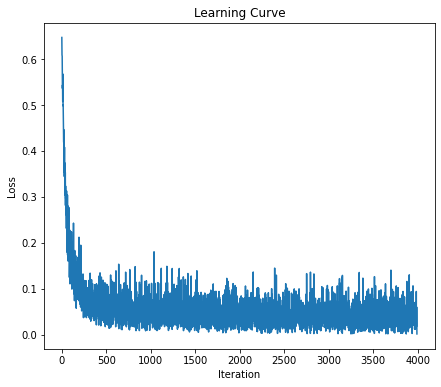

In [ ]:
# plotting learning curve
plt.figure(figsize=(7,6))
plt.plot(range(1, 3991), losses)
plt.title('Learning Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [17]:
# validating the model on different metrics
def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        with tqdm(val_loader, unit = "batch") as tepoch:
            for _, data in enumerate(tepoch, 0):
                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.float)
                outputs = model(ids, mask, token_type_ids)
                fin_targets.extend(targets.cpu().detach().numpy().tolist())
                fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
                
    return fin_outputs, fin_targets

In [20]:
for epoch in range(EPOCHS):
    outputs, targets = validation(epoch)
    outputs = np.array(outputs) >= 0.5
    accuracy = metrics.accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")

100%|██████████| 1995/1995 [13:31<00:00,  2.46batch/s]


Accuracy Score = 0.9276515744947517
F1 Score (Micro) = 0.789772319184084
F1 Score (Macro) = 0.6182430791051402


In [18]:
# saving the trained model for inference
PATH = '../models/fine_tuned/toxic_model.pth'

In [ ]:
torch.save(model.state_dict(), PATH)